# Onset Benchmark

<a href="https://colab.research.google.com/github/inspektral/onset-benchmark/blob/main/onset-benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [30]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'onset-benchmark'
    repo_path = f'/content/{repo_name}'
    
    # Check if the current working directory is already the repo
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/onset-benchmark.git
        os.chdir(repo_path)  # Change to the repository directory
        !pip install -r requirements.txt  # Install dependencies
        !git clone https://github.com/inspektral/music2latent.git

In [31]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa

import utils

In [32]:
import test_signals

tests = {}

for name, obj in vars(test_signals).items():
    if callable(obj):
        tests[name] = obj

print("Available tests:")
for i, name in enumerate(tests.keys()):
    print(f"{i}: {name}")

Available tests:
0: square_slow
1: square_fast
2: square_vibrato
3: saw_noise
4: sines_noise
5: filter_saw
6: triangle_clip
7: fm_amplitude
8: fm_frequency
9: delay_noise
10: delay_saw
11: reverb_noise
12: reverb_saw


In [33]:
SAMPLE_RATE = 44100
CURRENT_TEST = 6
SMALL = False

Running test: triangle_clip


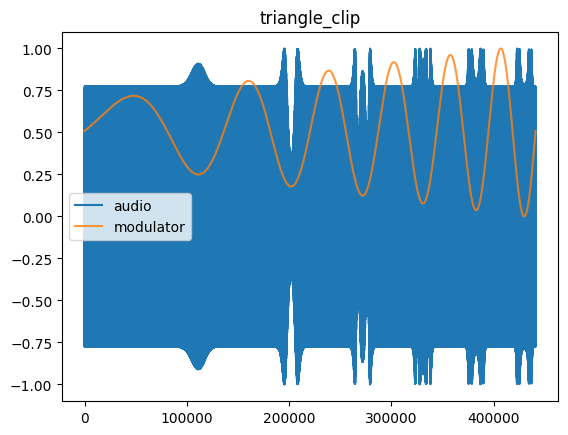

In [34]:
test = tests[list(tests.keys())[CURRENT_TEST]]
print(f"Running test: {test.__name__}")
test_name = test.__name__
audio, modulator = test()

plt.plot(audio, label='audio')
modulator = utils.norm(synth.stretch_array(modulator, len(audio)))
plt.plot(modulator, alpha=0.8, label='modulator')
plt.title(test.__name__)
plt.legend()

plt.show()

display(Audio(audio, rate=SAMPLE_RATE)) 

In [35]:
representations = utils.get_representations(audio)

Computing mfcc representation...
Computing cqt representation...
Computing spectrum representation...
Computing music2latent representation...
Computing dac representation...


/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [36]:
print(representations.keys())

dict_keys(['mfcc', 'cqt', 'spectrum', 'music2latent', 'dac'])


In [37]:
import ipywidgets as widgets
from IPython.display import display

# Create checkboxes for all available representations
available_reps = list(representations.keys())
checkbox_widgets = {rep: widgets.Checkbox(
    value=rep in ['mfcc', 'cqt', 'spectrum', 'music2latent', 'dac'],
    description=rep,
    disabled=False
) for rep in available_reps}

# Create output widget to display results
output = widgets.Output()

def update_representations(change):
    with output:
        output.clear_output()
        to_keep = [rep for rep, checkbox in checkbox_widgets.items() if checkbox.value]
        global filtered_repr
        filtered_repr = {k: v for k, v in representations.items() if k in to_keep}
        print(f"Filtered representations: {list(filtered_repr.keys())}")

# Create a button to apply changes
apply_button = widgets.Button(description="Apply Selection")
apply_button.on_click(lambda b: update_representations(None))

# Layout the widgets
vbox_checkboxes = widgets.VBox([checkbox_widgets[rep] for rep in available_reps])
widget_box = widgets.VBox([
    widgets.Label("Select representations to keep:"), 
    vbox_checkboxes, 
    apply_button, 
    output
])

# Display the widget
display(widget_box)

# Initial filtering
to_keep = [rep for rep, checkbox in checkbox_widgets.items() if checkbox.value]
filtered_repr = {k: v for k, v in representations.items() if k in to_keep}

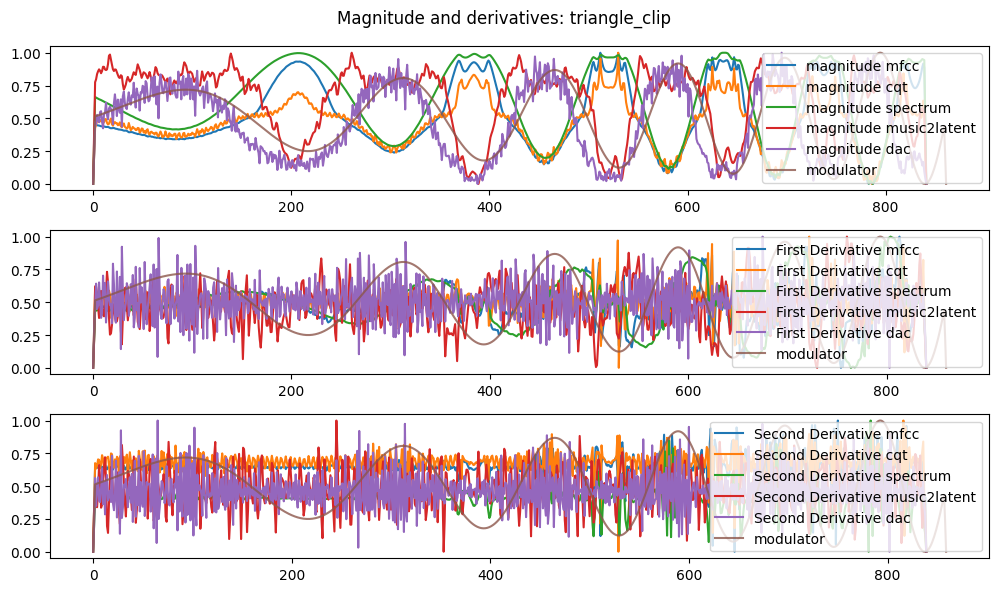

In [38]:
magnitude, d_magnitude, dd_magnitude = utils.calculate_metric(filtered_repr, np.linalg.norm, {"axis": 0})


utils.plot_with_derivatives(
    magnitude,
    d_magnitude,
    dd_magnitude,
    modulator,
    label="magnitude",
    title="Magnitude and derivatives: "+test_name,
    small=SMALL
)

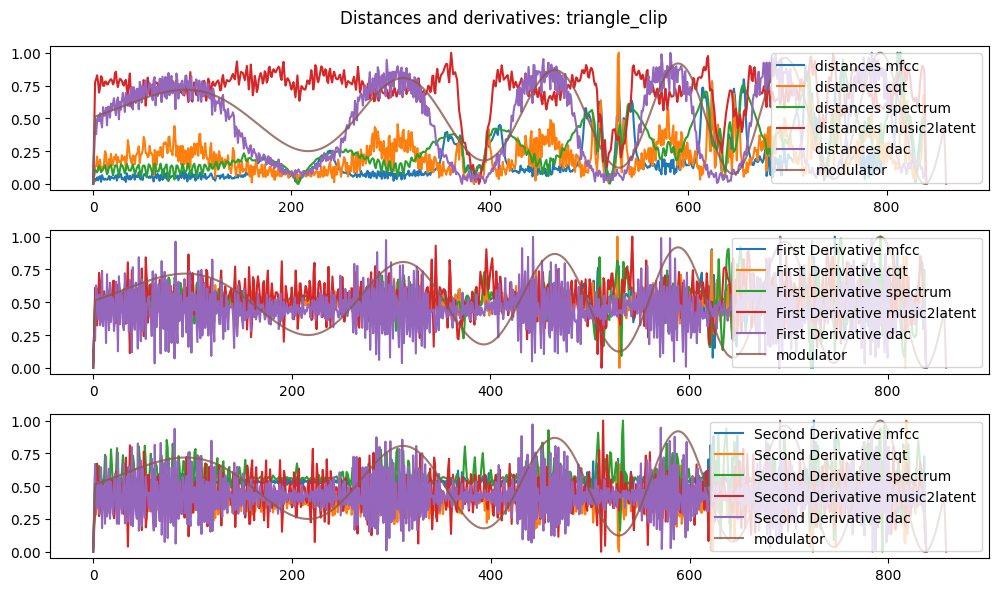

In [39]:
distances, d_distances, dd_distances = utils.calculate_metric(filtered_repr, utils.distances)

utils.plot_with_derivatives(
    distances,
    d_distances,
    dd_distances,
    modulator,
    label="distances",
    title="Distances and derivatives: "+test_name,
    small=SMALL
)


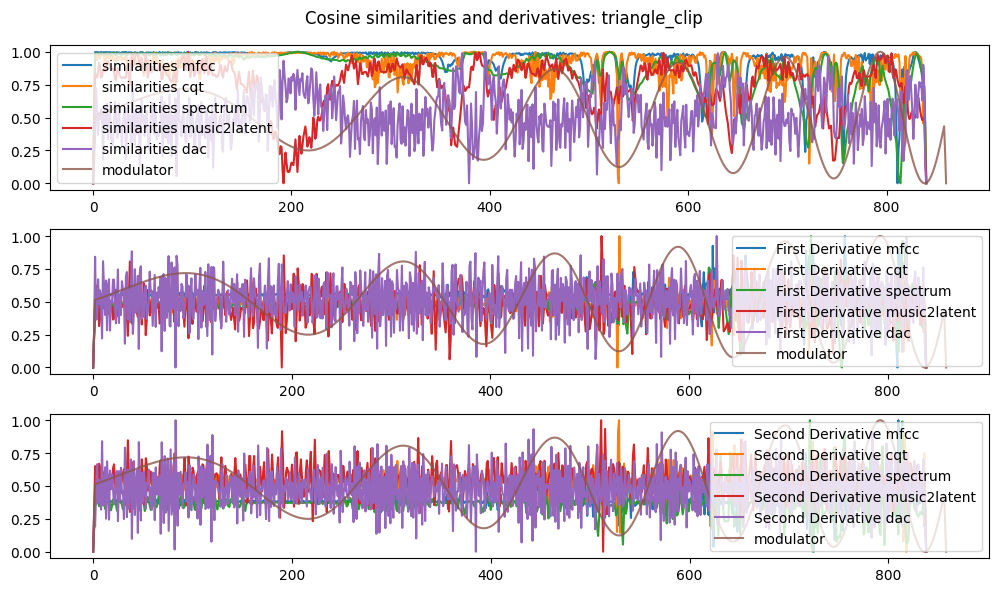

In [40]:
similarities, d_similarities, dd_similarities = utils.calculate_metric(filtered_repr, utils.cosine_similarity)

utils.plot_with_derivatives(
    similarities,
    d_similarities,
    dd_similarities,
    modulator,
    label="similarities",
    title="Cosine similarities and derivatives: "+test_name,
    small=SMALL
)

In [41]:
from scipy.signal import correlate, correlation_lags

def calculate_correlation(repr:dict, modulator:np.ndarray) -> dict:
    correlation = {}
    for key in repr.keys():
        x = repr[key]
        x = utils.stretch_array(x, len(modulator))

        y = modulator[10:-10]
        y = utils.norm(y)

        x = x[10:-10]
        x = utils.norm(x)
    
        correlation[key] = np.corrcoef(x, y)[0, 1]
    return correlation

correlation_magnitude = calculate_correlation(magnitude, modulator)
correlation_distances = calculate_correlation(distances, modulator)
correlation_similarities = calculate_correlation(similarities, modulator)

print("Correlation with modulator (magnitude):")
for key in filtered_repr.keys():
    print(f"{key}: {correlation_magnitude[key]:.4f}")
print(f"best representation: {max(correlation_magnitude.keys(), key=lambda k: np.abs(correlation_magnitude[k]))}")

print("Correlation with modulator (distances):")
for key in filtered_repr.keys():
    print(f"{key}: {correlation_distances[key]:.4f}")
print(f"best representation: {max(correlation_distances.keys(), key=lambda k: np.abs(correlation_distances[k]))}")

print("Correlation with modulator (similarities):")
for key in filtered_repr.keys():
    print(f"{key}: {correlation_similarities[key]:.4f}")
print(f"best representation: {max(correlation_similarities.keys(), key=lambda k: np.abs(correlation_similarities[k]))}")


Correlation with modulator (magnitude):
mfcc: -0.9625
cqt: -0.7909
spectrum: -0.9190
music2latent: 0.7405
dac: 0.9580
best representation: mfcc
Correlation with modulator (distances):
mfcc: -0.3007
cqt: 0.2041
spectrum: -0.1280
music2latent: 0.1962
dac: 0.9609
best representation: dac
Correlation with modulator (similarities):
mfcc: 0.0200
cqt: -0.0557
spectrum: 0.0747
music2latent: 0.6799
dac: -0.4774
best representation: music2latent


In [42]:
import pandas as pd

LOAD_DATA = True

In [43]:
results = pd.DataFrame()

if LOAD_DATA:
    results = pd.read_csv('results.csv')

else:

    for i, key in enumerate(tests.keys()):
        print(f"Running test: {key}, number {i+1}/{len(tests)}")
        audio, modulator = tests[key]()
        representations = utils.get_representations(audio)

        magnitude, _, _ = utils.calculate_metric(representations, np.linalg.norm, {"axis": 0})
        distances, _, _ = utils.calculate_metric(representations, utils.distances)
        similarities, _, _ = utils.calculate_metric(representations, utils.cosine_similarity)

        correlation_magnitude = calculate_correlation(magnitude, modulator)
        correlation_distances = calculate_correlation(distances, modulator)
        correlation_similarities = calculate_correlation(similarities, modulator)

        row = {
            'test': key,
            **{"magnitude_" + k: v for k, v in correlation_magnitude.items()},
            **{"distances_" + k: v for k, v in correlation_distances.items()},
            **{"similarities_" + k: v for k, v in correlation_similarities.items()}
        }

        results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)
        results.to_csv('results.csv', index=False)
        print("Results saved to results.csv")

        LOAD_DATA = True


In [44]:
display(results)

,test,magnitude_mfcc,magnitude_cqt,magnitude_spectrum,magnitude_music2latent,magnitude_dac,distances_mfcc,distances_cqt,distances_spectrum,distances_music2latent,distances_dac,similarities_mfcc,similarities_cqt,similarities_spectrum,similarities_music2latent,similarities_dac
0,square_slow,-0.863168,-0.922163,-0.955217,0.964625,0.839968,-0.595327,0.527020,0.236940,0.936386,0.837657,-0.474831,-0.698102,-0.367826,-0.826757,0.309650
1,square_fast,-0.695957,-0.714455,-0.600215,0.250383,0.859426,0.124003,0.352037,0.163505,0.233335,0.773739,-0.271611,-0.465636,-0.165690,-0.230605,-0.630086
2,square_vibrato,0.219850,0.270950,0.115339,-0.084753,0.595602,0.011675,0.053098,-0.079361,0.497410,0.651012,0.081695,-0.020988,0.088413,-0.496670,-0.668412
3,saw_noise,0.957261,-0.843568,-0.398855,0.788227,0.232986,-0.200325,-0.039593,-0.032329,0.825996,0.377482,0.766728,-0.293381,-0.099809,-0.724808,-0.188379
4,sines_noise,0.276049,-0.647385,-0.498642,0.969288,0.808976,-0.194392,-0.198563,-0.057743,0.924499,0.798526,0.280134,-0.030737,-0.092931,-0.834286,-0.050152
5,filter_saw,-0.995261,-0.152295,-0.958194,0.587679,0.449053,-0.121774,0.125942,0.074602,0.164629,0.592523,0.002883,-0.238818,-0.024992,0.028900,-0.031456
6,triangle_clip,-0.962493,-0.790868,-0.919034,0.740505,0.958045,-0.300707,0.204065,-0.127958,0.196194,0.960912,0.019977,-0.055672,0.074717,0.679919,-0.477431
7,fm_amplitude,-0.876013,-0.845504,-0.795137,-0.859402,0.081217,-0.003129,0.519818,0.093104,0.628887,-0.099215,-0.023703,-0.352487,-0.045248,-0.872056,0.152830
8,fm_frequency,-0.412961,0.108063,0.275957,-0.516499,0.113006,-0.149792,-0.134861,-0.281791,-0.010646,-0.184083,0.049275,0.110568,0.255421,-0.474710,0.274515
9,delay_noise,-0.628374,-0.610053,-0.598582,-0.497673,0.371437,-0.202321,-0.138014,-0.224140,-0.161007,0.446682,-0.160288,-0.326312,-0.499433,0.160676,-0.177095


In [45]:
numeric_columns = results.select_dtypes(include=[np.number]).columns.tolist()
results[numeric_columns] = np.abs(results[numeric_columns])

averages = results.mean(numeric_only=True)
averages.sort_values(ascending=False, inplace=True)
display(averages)

magnitude_mfcc               0.663071
magnitude_cqt                0.601199
magnitude_music2latent       0.584991
magnitude_spectrum           0.566734
distances_dac                0.527040
magnitude_dac                0.483004
similarities_music2latent    0.433846
distances_music2latent       0.392002
similarities_dac             0.294542
similarities_cqt             0.269475
distances_cqt                0.203203
similarities_spectrum        0.198467
similarities_mfcc            0.191692
distances_mfcc               0.180921
distances_spectrum           0.126443
dtype: float64

## Optimizations

- Convexity compensation
- Smoothing
- NMF